# Lab 1: Problem 2 (TD-learning with policy improvement)

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend. The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    
    
FrozenLake-v1 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

More documentation: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/


In [88]:
%reload_ext autoreload
%autoreload 2

In [89]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

/Users/Akseldkw/coding/kretsinger/data/nb_log.log


In [90]:
env_vars = os.environ.copy()
wand_db_dir = env_vars["OUTPUT_DIR"] + "/wandb"

In [91]:
# wandb set up for logging runs online and moving them to the leaderboard
# you will need to create a wandb account when prompted, or if you already have an account login you can simply sign in.
# !pip install wandb -qqq
import wandb

wandb.login()
run = wandb.init(dir=wand_db_dir)

In [92]:
## DO NOT CHANGE THIS CELL
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv

# env = typing.cast(
#     FrozenLakeEnv, gym.make("FrozenLake-v1", is_slippery=True, success_rate=1)
# )
env = typing.cast(FrozenLakeEnv, gym.make("FrozenLake-v1"))
# env.seed(0)

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0.

In [93]:
from functools import wraps

## DO NOT CHANGE THIS CELL
# wrapper for accounting rewards
rEpisode = 0
rList = []
fixedWindow = 100
movingAverage = 0


def reset_decorate(func):
    @wraps(func)
    def func_wrapper(*args, **kwargs):
        global rList
        global movingAverage
        global rEpisode
        global fixedWindow
        rList.append(rEpisode)
        if len(rList) >= fixedWindow:
            movingAverage = np.mean(rList[len(rList) - fixedWindow : len(rList) - 1])
        rEpisode = 0
        return func(*args, **kwargs)

    return func_wrapper


env.reset = reset_decorate(env.reset)


def step_decorate(func):
    @wraps(func)
    def func_wrapper(*args, **kwargs):
        global rEpisode
        # Call the original step function and unpack the result
        result = func(*args, **kwargs)
        # Handle both 4-tuple and 5-tuple returns for compatibility
        if len(result) == 5:
            s1, r, d, other, info = result
            rEpisode += r
            return (s1, r, d, other, info)
        else:
            raise ValueError("Unexpected number of return values from env.step")

    return func_wrapper


env.step = step_decorate(env.step)


def init():
    rEpisode = 0
    rList = []
    movingAverage = 0
    return

Below we illustrate the execution of the Open AI gym enviornment using the policy of chosing random action in every state. Every time an action is taken the enviorment returns a tuple containing next state, reward, and the status (whether terminal state is reached or not).

In [94]:
### RANDOM SAMPLING EXAMPLE
num_episodes = 1000
# number of episodes you want to try
episode_max_length = 100
# you can explicitly end the epsiode before terminal state is reached

env.reset()
# env.render()
# execute in episodes
for i in range(num_episodes):

    # reset the environment at the beginning of an episode
    s = env.reset()
    d = False  # not done

    for t in range(episode_max_length):

        ################ Random action policy ###########################
        # play random action
        a = env.action_space.sample()
        # get new state, reward, done
        s, r, d, _, info = env.step(a)
        #################################################################

        # break if done, reached terminal state
        if d == True:
            break

    # log per-episode reward and moving average over 100 episodes
    wandb.log(
        {
            "random reward": rEpisode,
            "random reward moving average": movingAverage,
            "random episode": i,
        }
    )

Implement tabular TD-learning with policy improvement (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [95]:
"""I'm moving this into its own cell so as to avoid resetting Q and n every time I re-run the training cell."""

env.observation_space = typing.cast(gym.spaces.Discrete, env.observation_space)
env.action_space = typing.cast(gym.spaces.Discrete, env.action_space)
# create Q table

Q = np.zeros([env.observation_space.n, env.action_space.n])  # matrix Q[s,a]
# create policy
pi = np.random.randint(
    low=env.action_space.n, size=env.observation_space.n
)  # array pi[s]

In [96]:
dtt(Q, pi, names=["Q", "pi"])

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [97]:
# initialize discount factor, learning rate
gamma = 0.95
learnRate = 0.80

# initialize episodic structure
episode_max_length = 100
num_episodes = 1000


def learnRate_decay(
    episode: int, initial_lr: float = 0.8, decay_rate: float = 0.99, min_lr: float = 0.1
) -> float:
    """
    Decay the learning rate over episodes.
    """
    return max(min_lr, initial_lr * (decay_rate**episode))


def policy_improvement() -> tuple[np.ndarray, bool]:
    """
    Greedy improvement: π[s] = argmax_a Q[s, a]
    Returns (new_pi, stable_flag).
    """
    # global Q, pi
    new_pi = pi.copy()
    for s in range(Q.shape[0]):
        new_pi[s] = int(np.argmax(Q[s, :]))
    stable = np.array_equal(new_pi, pi)
    return new_pi, stable


def policy_evaluation_td0(on_policy_eps: float = 0.4) -> None:
    """
    Evaluate current policy π using on-policy TD(0) updates over Q.
    Only Q[s, π[s]] is updated (policy evaluation, not control).
    If on_policy_eps > 0, we use an ε-soft version of π during evaluation.
    """

    for ep in range(num_episodes):
        obs = env.reset()
        s = int(obs[0]) if isinstance(obs, tuple) else int(obs)
        terminated = False
        truncated = False

        for t in range(episode_max_length):
            if np.random.rand() < on_policy_eps:
                # explore: random action
                a = env.action_space.sample()
            else:
                a = int(pi[s])

            # step
            state, reward, terminated, truncated, info = env.step(a)

            if terminated or truncated:
                target = reward
            else:
                a_next = int(pi[state])
                target = reward + gamma * Q[state, a_next]

            td_err = target - Q[s, a]
            alpha = learnRate_decay(ep)
            Q[s, a] += alpha * td_err

            if terminated or truncated:
                break
            s = state

In [98]:
run = wandb.init(dir=wand_db_dir)

random episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
random reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
random reward moving average,▁▁▁▁▆▆▃▃▁▁▁▁▁▁▃▆▆██▆▆▆▆▃▁▁▁▃▃▃▁▃▃▁▁▁▁▁▁▆
random episode,999
random reward,0
random reward moving average,0.0303


In [101]:
init()

env.observation_space = typing.cast(gym.spaces.Discrete, env.observation_space)
env.action_space = typing.cast(gym.spaces.Discrete, env.action_space)


def print_condition(stable: bool = False):
    return False


# SET POLICY ITERATION k=1,2...
rounds = 5
# RESET Q values

# execute in episodes
for k in tqdm.tqdm(range(rounds)):
    Q = np.zeros([env.observation_space.n, env.action_space.n])  # matrix Q[s,a]

    # reset the environment at the beginning of an episode
    reset_state = env.reset()
    s = reset_state[0]

    for t in range(episode_max_length):
        policy_evaluation_td0()

        # 2) Improve policy
        new_pi, stable = policy_improvement()
        if print_condition(stable):
            print(f"[PI round {k}] π = {list(new_pi)}   (stable={stable})")

        pi = new_pi
        if stable:
            if print_condition(stable):
                print(f"Policy stable after {k} rounds.")
            break

    # log per-episode reward and moving average over 100 episodes
    wandb.log(
        {
            "training reward": rEpisode,
            "training reward moving average": movingAverage,
            "training episode": i,
        }
    )

wandb.run = typing.cast(wandb.Run, wandb.run)
wandb.run.summary["number of training episodes"] = num_episodes

#### improve policy pi

100%|██████████| 5/5 [00:23<00:00,  4.60s/it]


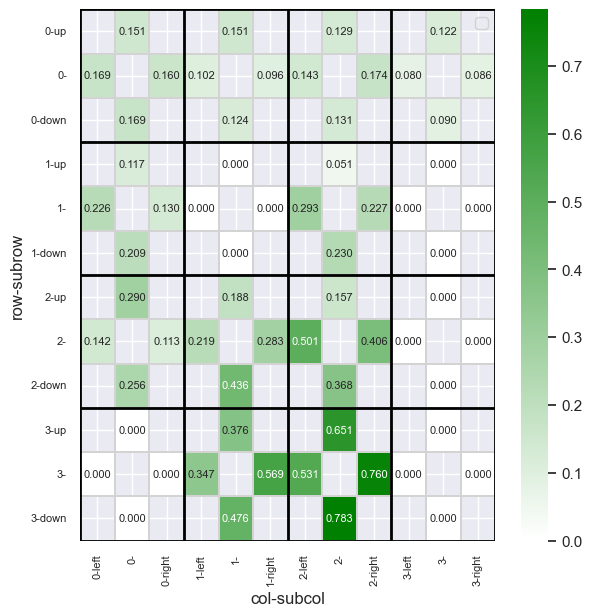

In [102]:
fig, ax = uks_mpl.subplots(1, 1, width_per=6, height_per=6)
q_detailed = uks_gym.q_val_viz.q_to_expanded_grid(Q)
uks_gym.q_val_viz.expanded_heatmap_with_state_borders(q_detailed, ax)
fig

In [85]:
%%wandb
## DO NOT CHANGE THIS CELL. CHANGING ANY PART OF THIS CELL CAN DISQUALIFY THE SUBMISSION
#Evaluation of trained policy
init()
num_episodes=1000; #number of episodes for evaluation
episode_max_length=100
movingAverageArray=[]
score=0
env.reset()
for i in range(num_episodes):
    reset_state = env.reset()
    s = reset_state[0]
    d = False #not done
    for t in range(episode_max_length):
        a = int(pi[s])
        s, r, d, _, _ = env.step(a)

        if d == True:
            break
    #log per-episode reward and moving average over 100 episodes
    wandb.log({ "evaluation reward" : rEpisode, "evaluation reward moving average" : movingAverage, "evaluation episode" : i})
    movingAverageArray.append(movingAverage)
    #score is x if there is a window of 100 consecutive episodes where moving average was at least x
    if i>100:
        score=max(score,min(movingAverageArray[i-100:i-1]))

wandb.run.summary["score"]=score

In [86]:
score

np.float64(0.797979797979798)

In [87]:
run.finish()

evaluation episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇████
evaluation reward,▁████▁▁██▁███▁█▁███████████▁██▁█▁█▁▁▁▁█▁
evaluation reward moving average,▆▆▆▅▆▄▃▄▄▅▁▂▃▃▃▁▁▁▂▃▂▂▃▃▂▃▅▆███▇▆▃▃▂▃▃▃▃
evaluation episode,999
evaluation reward,0
evaluation reward moving average,0.72727
score,0.79798
